In [1]:
using Pkg
Pkg.activate("deconvolution"; shared=true)

"/Users/imolk/Library/Julia/environments/deconvolution/Project.toml"

In [2]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
using Optim
using Distributions
import Random

using Revise
using DeconvolveDistribution
using DeconvolveDistribution: coefs, ExpoSpline
;

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/DeconvolveDistribution/2elKn.ji for DeconvolveDistribution [ce248477-2e98-51a1-a641-d405f74c103f]
└ @ Base loading.jl:1185
┌ Warning: Package DeconvolveDistribution does not have StatsBase in its dependencies:
│ - If you have DeconvolveDistribution checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DeconvolveDistribution
└ Loading StatsBase into DeconvolveDistribution from project dependency, future warnings for DeconvolveDistribution are suppressed.


In [28]:
# simulate some data
n = 400
F_X = MixtureModel([Normal(-1, 1), Normal(2, 0.8)], [0.6, 0.4])
σ_distr = Gamma(1.0, 4.0)
Random.seed!(1)
X = rand(F_X, n)
σ = rand(σ_distr, n)
U_distr = Normal.(0.0, σ)
U = rand.(U_distr)
W = X .+ U
;

# Fourier

In [36]:
# estimate F_X from simulated data
n_xx = 500
F_xx = collect(range(-8.0, stop=8.0, length=n_xx))
num_t = 50
h = 0.3
;

In [37]:
decon_settings = DeconvolveDistribution.FourierDeconv(h, F_xx, num_t)
decon_distr = DeconvolveDistribution.decon(decon_settings, W, U_distr)
;

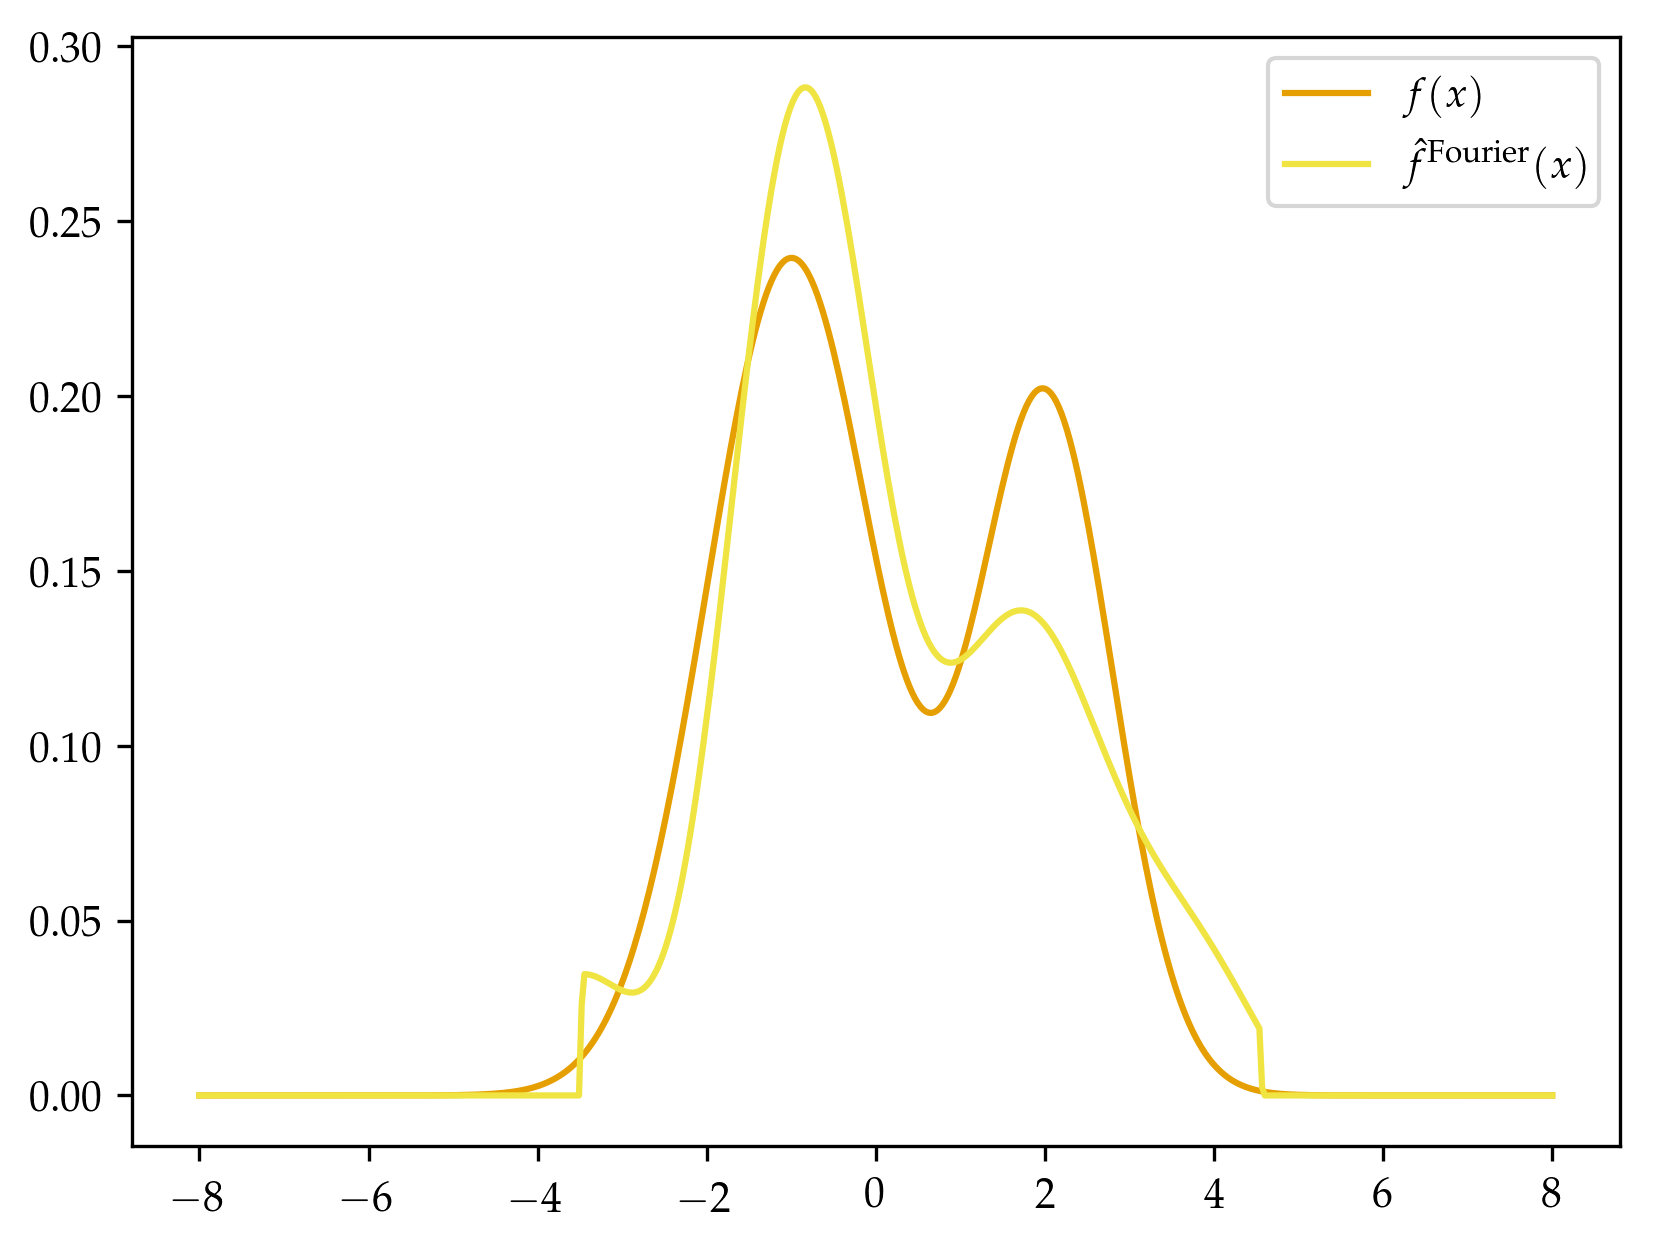

PyObject <matplotlib.legend.Legend object at 0x14a425ac8>

In [38]:
plt.plot(F_xx, pdf.(F_X, F_xx), color=cbbPalette[1], label=L"f(x)")

fhat_decon_distr = pdf.(decon_distr, F_xx)
plt.plot(F_xx, fhat_decon_distr, color=cbbPalette[4], label=L"\hat{f}^{\mathrm{Fourier}}(x)")

# plt.plt[:hist](rand(decon_distr, 10_000), bins=100, normed=true, alpha=0.2)

plt.legend(loc="top left")

# Efron

In [7]:
function plot_pdf(d::DeconvolveDistribution.ExpoSpline; kwargs...)
    p = pdf(d)
    θ = d.domain
    Δ = median(diff(θ))
    plt.bar(θ, p./Δ, Δ; kwargs...)
end

plot_pdf (generic function with 1 method)

In [8]:
Random.seed!(3)
θvec = collect(range(-5,stop=5,length=61))
d = ExpoSpline(θvec, randn(8))
;

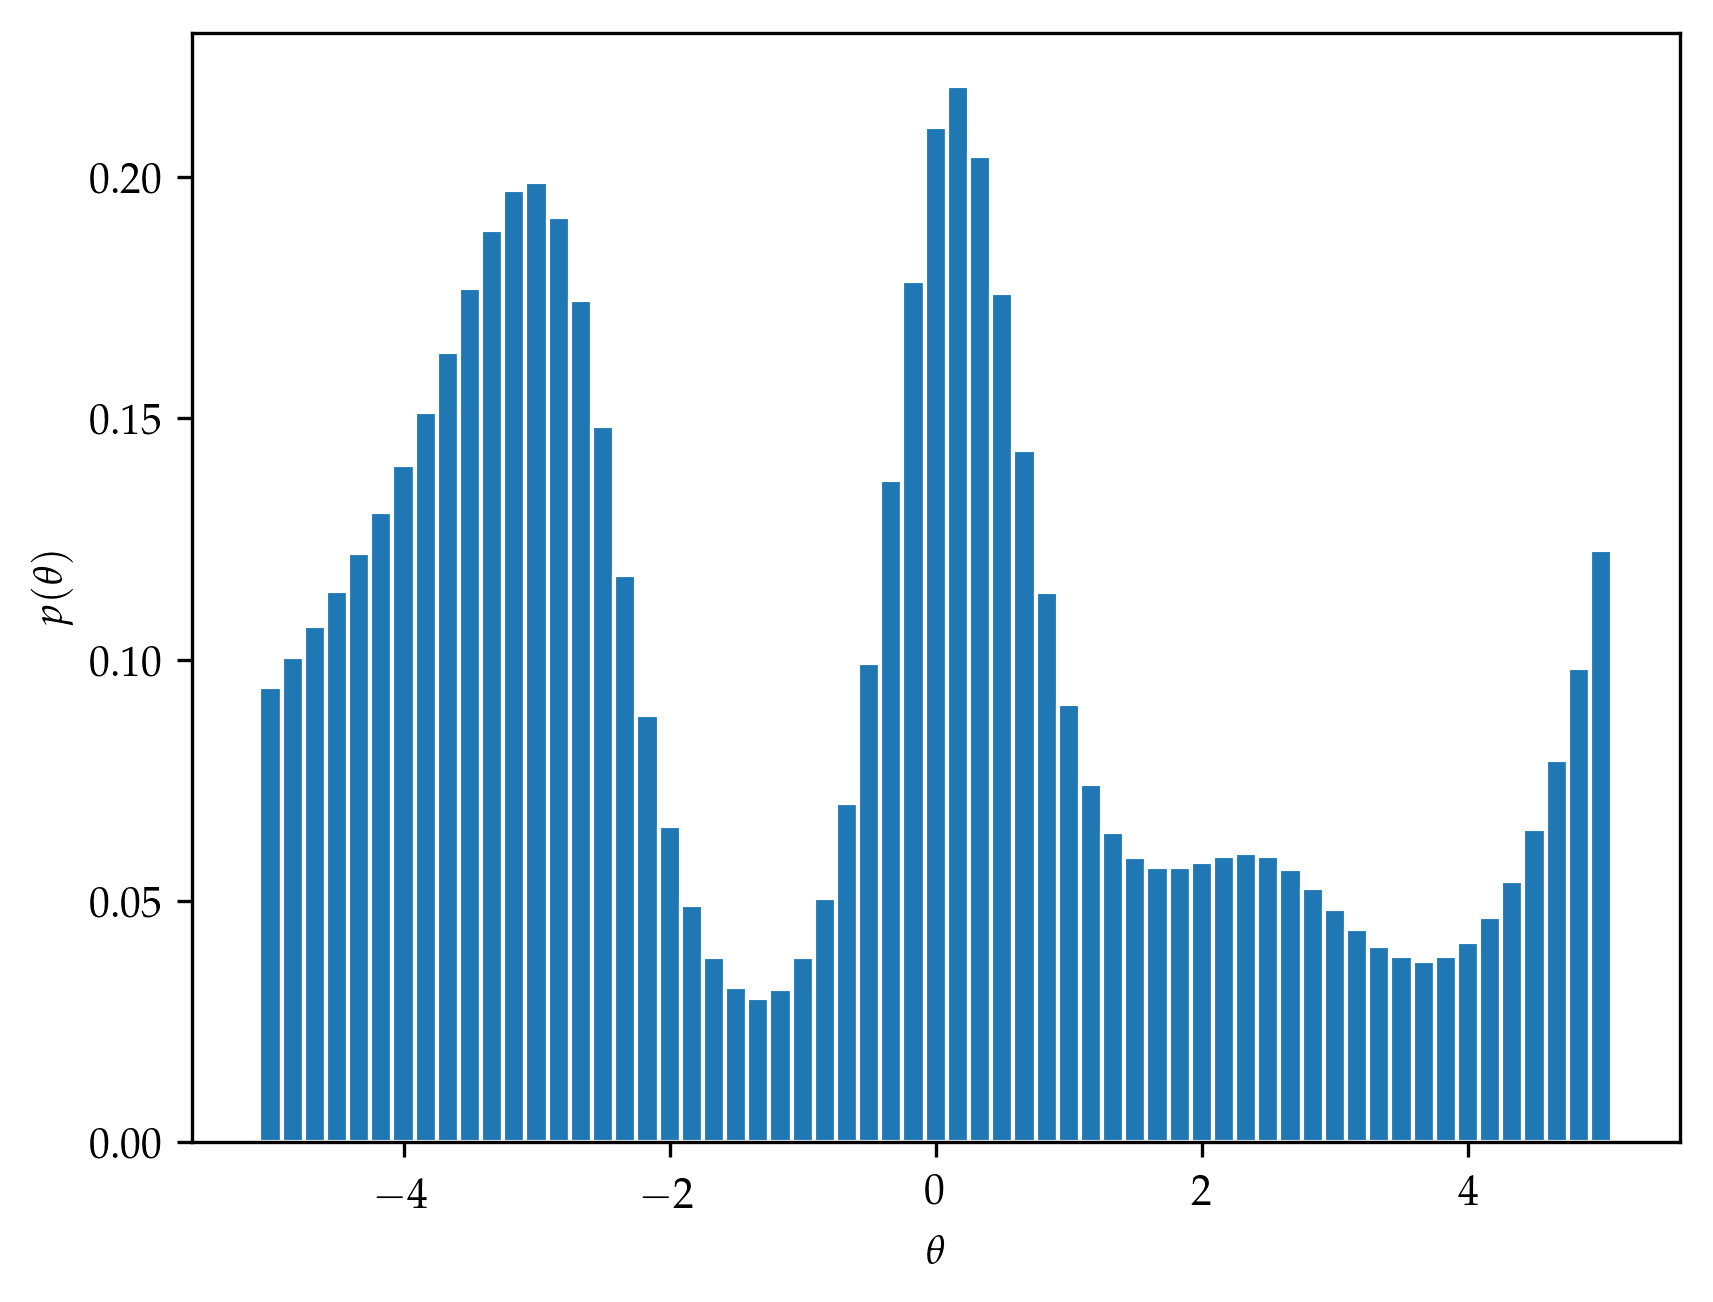

In [9]:
plot_pdf(d, edgecolor="white")
plt.xlabel(L"\theta")
plt.ylabel(L"p(\theta)")
;

In [19]:
dm = DeconvolveDistribution.EfronDeconv(7, θvec, 2.0)
d_optim = DeconvolveDistribution.decon(dm, W, U_distr)
;

In [21]:
@time d_optim = DeconvolveDistribution.decon(dm, W, U_distr);

  0.284368 seconds (43.25 k allocations: 336.008 MiB, 23.82% gc time)


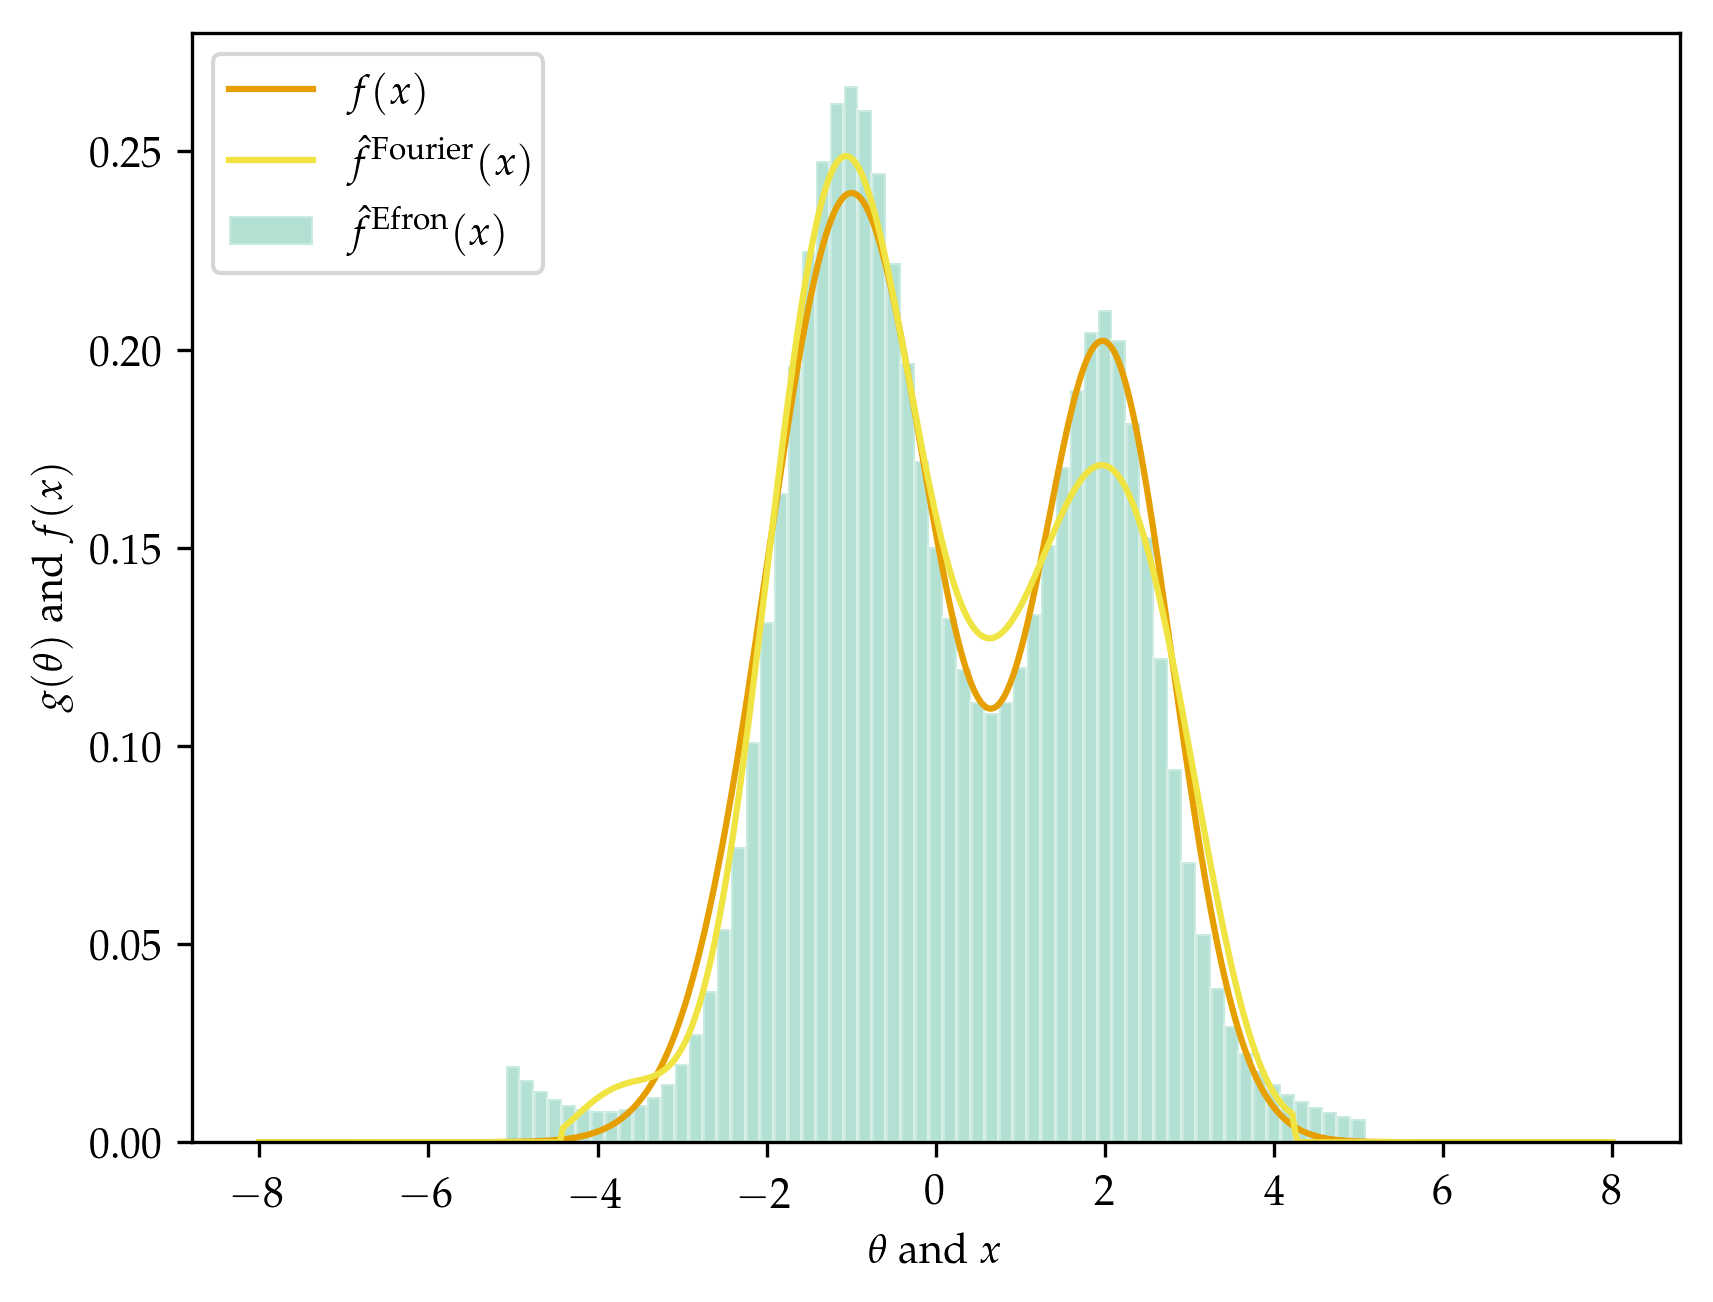

In [25]:
plt.plot(F_xx, pdf.(F_X, F_xx), color=cbbPalette[1], label=L"f(x)")
plot_pdf(d_optim; facecolor=cbbPalette[3], alpha=0.3, 
        edgecolor="white", label=L"\hat{f}^{\mathrm{Efron}}(x)")
plt.plot(F_xx, fhat_decon_distr, color=cbbPalette[4], label=L"\hat{f}^{\mathrm{Fourier}}(x)")
plt.ylabel(L"$g(\theta)$ and $f(x)$")
plt.xlabel(L"$\theta$ and $x$")
plt.legend(loc="upper left")
;